# DAY57

昨天说了数据的检验，需要做自相关性检验、平稳性检验、季节性检验。
我们用了三种核心的诊断工具：

1. 自相关性检验 (ACF/PACF图)：检查数据点之间是否存在内在的、延迟的关联。
2. 平稳性检验 (ADF检验)：判断数据的统计特性（如均值、方差）是否随时间改变。
3. 季节性检验 (肉眼观察或季节性分解)：识别数据中是否存在固定的周期性波动。


那么如果数据存在某些特性需要如何处理呢？

我们的核心目标是让数据变得平稳。为什么平稳性如此重要？因为绝大多数经典的时间序列模型（比如ARIMA模型）都建立在一个基本假设之上：数据的统计特性是恒定的。如果数据不平稳，就像一个人的脾气阴晴不定，模型就很难抓住其规律，预测自然也就不准了。

我们今天会针对两大“病症”进行处理：非平稳性和季节性。而自相关性，我们则需要换个思路，它不是一个要消除的“病症”，反而是我们要利用的“特征”，我们最后会讲到。

# 一、序列数据的处理

## 处理非平稳性

通过昨天的ADF检验，我们发现p值显著大于0.05，这表明数据是非平稳的。通常，这意味着数据存在趋势（Trend），比如股价长期来看在上涨，或者销量逐年递增。

核心疗法：差分 (Differencing)



差分是解决趋势性问题的最强有力的工具。它的思想非常简单：用后一个时间点的值减去前一个时间点的值。这样做的效果是，它消除了数据在“水平”上的变化，转而关注数据“变化的速度”。  


一阶差分  
$$\text{diff}_1 = y_t - y_{t-1}$$  
这通常能有效地消除线性的趋势。  


如果一阶差分后数据仍然不平稳怎么办？那就再做一次！  

二阶差分  
$$\text{diff}_2 = \text{diff}_{1_t} - \text{diff}_{1_{t-1}} = (y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$$  
这可以处理更复杂的（例如，曲线形的）趋势。  



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 设置中文字体，防止matplotlib显示乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 生成一段非平稳数据（随机游走+趋势）
np.random.seed(42)
# 随机游走部分
random_walk = np.random.randn(500).cumsum() # 累积和生成随机游走
# 添加一个线性趋势
trend = np.linspace(0, 100, 500)
# 合成我们的时序数据
data = pd.Series(random_walk + trend)
data.index = pd.date_range(start='2022-01-01', periods=500)

随机游走（Random Walk）是一种数学模型，常用于描述随机过程中的路径变化。在随机游走模型中，每一步的方向和大小都是随机确定的，且与之前的步骤相互独立。这种模型可以用来模拟股票价格、分子运动、赌博结果等具有不确定性的现象。

上述代码为了合成一个具有趋势性和随机性的时间序列，它结合了随机游走和线性趋势的特征

Text(0.5, 1.0, '原始数据（有明显趋势）')

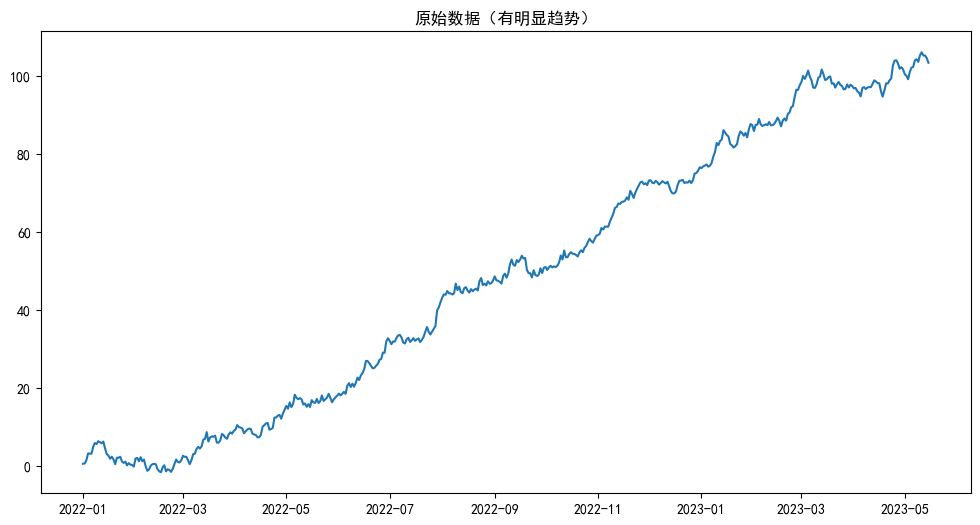

In [14]:
# 2. 诊断原始数据
plt.figure(figsize=(12, 6))

plt.plot(data)
plt.title('原始数据（有明显趋势）')

In [15]:
# ADF检验
adf_result_original = adfuller(data)
print(f'原始数据的ADF检验结果:')
print(f'  ADF Statistic: {adf_result_original[0]}')
print(f'  p-value: {adf_result_original[1]}') # p-value会非常大，说明是非平稳的

原始数据的ADF检验结果:
  ADF Statistic: 0.13578365336168233
  p-value: 0.9684209812957272


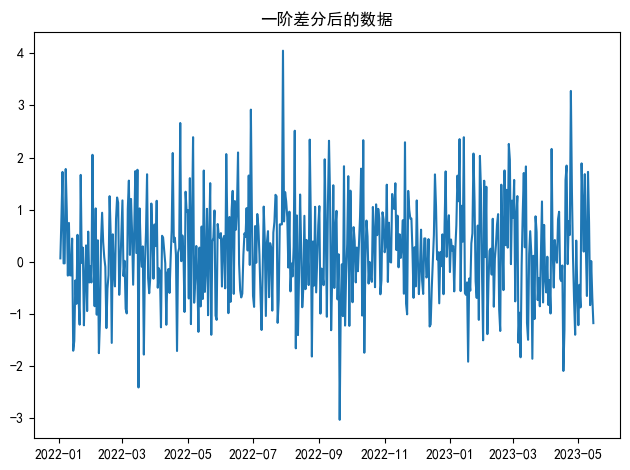

一阶差分后数据的ADF检验结果:
  ADF Statistic: -22.313025583815016
  p-value: 0.0


In [16]:
# 3. 进行一阶差分治疗
data_diff = data.diff().dropna() # .diff()进行差分, .dropna()移除第一个NaN值


plt.plot(data_diff)
plt.title('一阶差分后的数据')
plt.tight_layout()
plt.show()

# 4. 诊断“治疗后”的数据
adf_result_diff = adfuller(data_diff)
print(f'一阶差分后数据的ADF检验结果:')
print(f'  ADF Statistic: {adf_result_diff[0]}')
print(f'  p-value: {adf_result_diff[1]}') # p-value会变得非常小，说明数据变平稳了


我们使用了data.diff()进行了一阶差分。从图中可以清晰地看到，原本一路向上的趋势消失了，数据开始围绕一个固定的均值（0附近）波动。

## 处理季节性

通过观察图像或季节性分解，我们发现数据存在以年、季度或月为单位的固定周期性波动。

核心疗法：季节性差分 (Seasonal Differencing)

思想和普通差分非常类似，但不是减去上一个值，而是减去上一个周期的对应值。

季节性差分公式如下：  

 
$$\text{seasonal\_diff} = y_t - y_{t-s}$$  

其中 \( s \) 是季节性周期。例如：  
- 对于月度数据，年度季节性周期 \( s = 12 \)；  
- 对于季度数据，年度季节性周期 \( s = 4 \)。

下面生成一段带有明显季节性特征的数据。

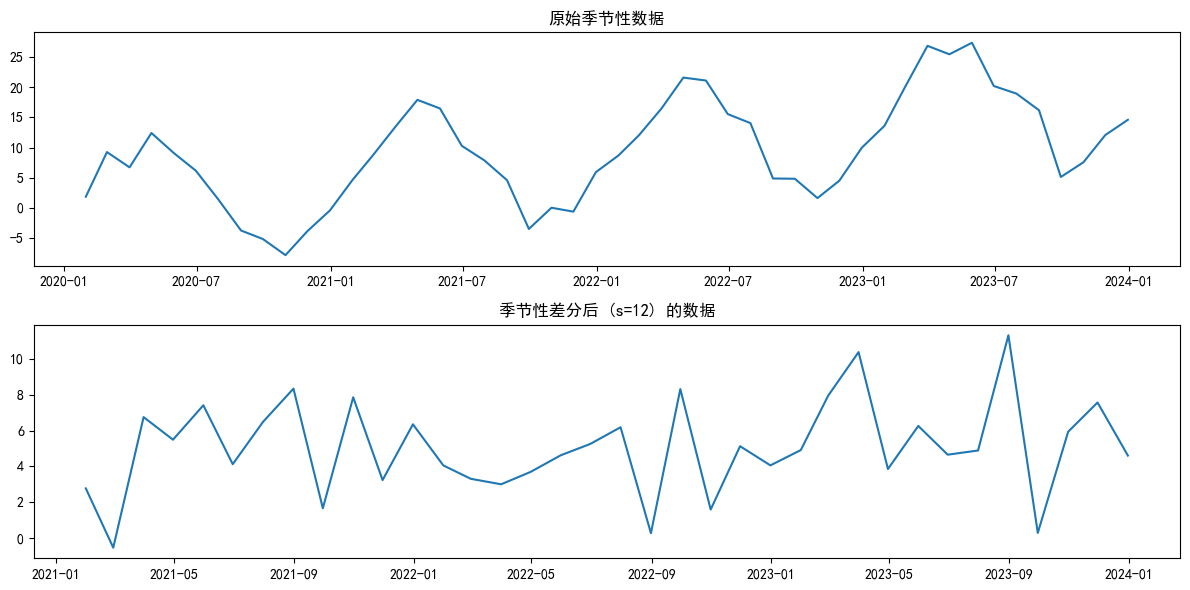

原始季节性数据的p-value: 0.9918566279818364
季节性差分后数据的p-value: 4.596236388830458e-12


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1. 生成一段有季节性的数据
# 假设是4年的月度数据，周期为12
time_index = pd.date_range(start='2020-01-01', periods=48, freq='M')
# 季节性成分（用sin函数模拟）
seasonal_component = np.sin(np.arange(48) * (2 * np.pi / 12)) * 10 # 振幅为10，周期为12个月，sin函数模拟季节性波动
# 趋势成分
trend_component = np.linspace(0, 20, 48) # linspace函数为生成0到20的线性趋势，包含48个点
# 随机噪声
noise = np.random.randn(48) * 2

# 合成数据
seasonal_data = pd.Series(seasonal_component + trend_component + noise, index=time_index)

# 2. 观察原始数据
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(seasonal_data)
plt.title('原始季节性数据')

# 3. 进行季节性差分（周期s=12）
seasonal_data_diff = seasonal_data.diff(periods=12).dropna()

plt.subplot(212)
plt.plot(seasonal_data_diff)
plt.title('季节性差分后 (s=12) 的数据')
plt.tight_layout()
plt.show()

# 4. 检查差分后的平稳性
# 注意：原始数据因为有趋势，肯定不平稳。季节性差分通常也能消除一部分趋势。
adf_result_original = adfuller(seasonal_data)
print(f'原始季节性数据的p-value: {adf_result_original[1]}')

adf_result_seasonal_diff = adfuller(seasonal_data_diff)
print(f'季节性差分后数据的p-value: {adf_result_seasonal_diff[1]}')

我们使用 seasonal_data.diff(periods=12)，这表示每个数据点都减去它12个月前的值。从图中可以看到，规律的波峰和波谷被“拉平”了，季节性特征被有效地移除了。

ADF检验的p值同样会从一个较大的值（因为原始数据含趋势）显著降低，证明数据在季节性差分后变得更加平稳。

如果数据既有趋势又有季节性，通常可以先做季节性差分，再对结果做一阶差分。

目前已经学会了如何通过差分来“驯服”那些不平稳和有季节性的数据，让它们变得温顺（平稳）。

现在，我们手上拿到了一份“健康”的平稳数据。接下来要做的，就是为它选择一个合适的模型。我们来深入了解时间序列预测的三大基石模型：AR、MA 和 ARMA。



模型的选择，依赖这些因素：
1. ACF 图 (自相关图)：衡量一个值和它所有过去值之间的关系，不管这些关系是直接的还是间接的。比如，Yt 和 Yt-2 的关系，也包含了 Yt-1 作为中间人的“传话效应”。
2. PACF 图 (偏自相关图)：只衡量一个值和它某个过去值之间的直接、纯粹的关系，排除了所有“中间人”的干扰。它回答的是：“在剔除了 Yt-1 的影响后, Yt-2 对 Yt 还有多少直接影响力？”

# 二、模型的选择

## 2.1 AR模型

AR模型 (Autoregressive Model) - “惯性模型”，全称自回归模型，是这三个模型中最直观的一个。

核心思想：未来是过去的延伸。一个时间点的值，很大程度上是由它紧邻的前几个时间点的值决定的。它认为时间序列数据具有一种“惯性”或“记忆性”。比如一只股票如果连续几天上涨，形成上涨趋势，那么它今天的价格也很有可能受到前几天价格的积极影响。

AR(p) 模型：表示当前值 Yt 只与它过去的 p 个值 (Yt-1, Yt-2, …, Yt-p) 有关。p 被称为模型的“阶数”


当一个序列的“惯性”是其主要特征时，AR模型是最佳选择。我们用侦探工具来判断：

技术指标：
1. PACF 图呈现“截尾” (Cuts off)：偏自相关图在延迟 p 阶之后，突然断崖式地落入置信区间。这说明，只有前 p 个时期的值对当前值有直接影响，更久远的影响几乎为零。
2. ACF 图呈现“拖尾” (Tails off)：自相关图的相关系数是缓慢、指数级下降的。这是因为 Yt-1 影响 Yt，Yt-2 影响 Yt-1，这种影响会像涟漪一样传递下去，导致ACF图缓慢衰减。
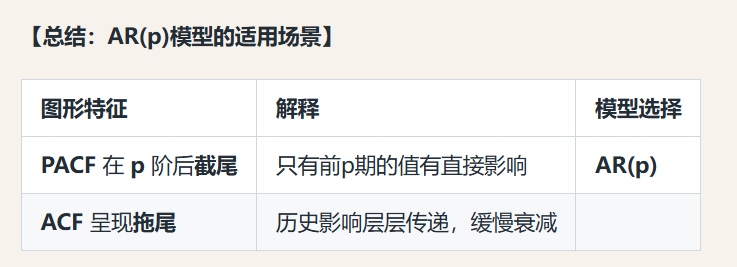

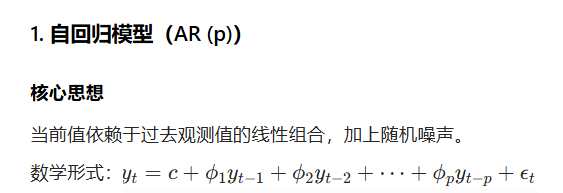

AR 模型更适合进行短期预测。因为随着预测期的延长，模型对过去值的依赖会导致误差不断累积，预测的准确性会逐渐降低。比如预测未来几天的气温，AR 模型可以利用过去几天的气温数据进行相对准确的短期预测。

--- 案例一：AR(2)模型 - 湖水温度 ---


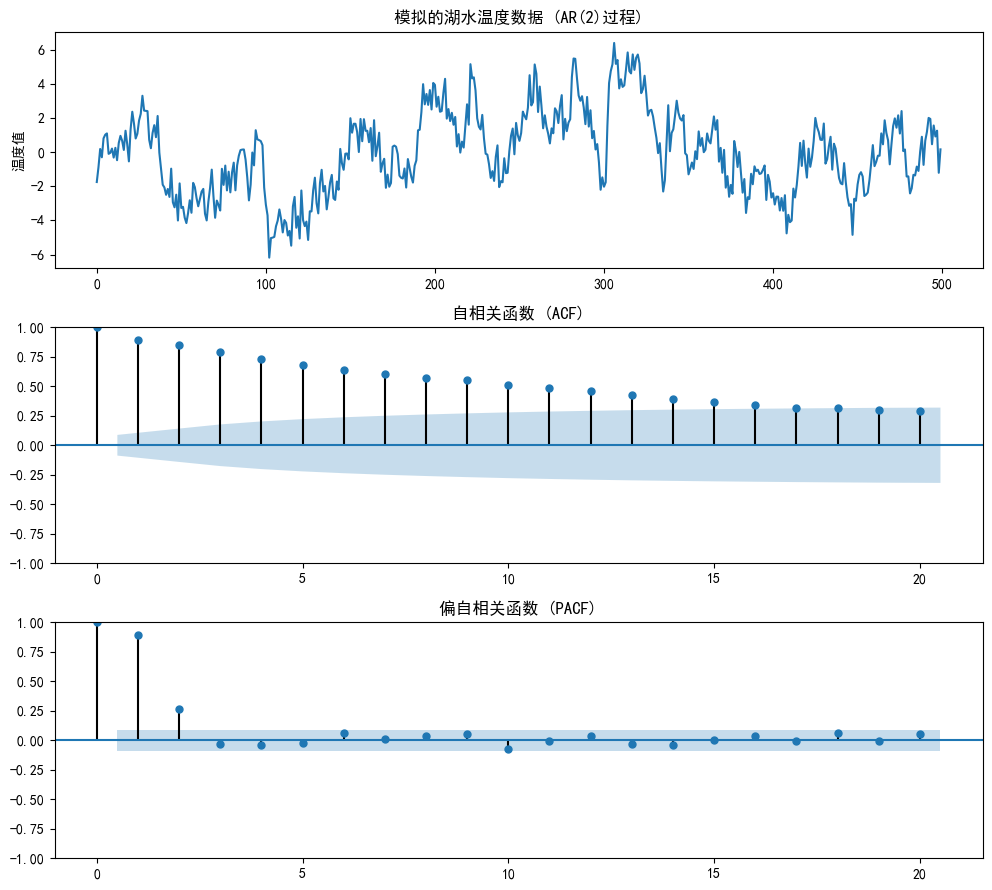

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# 设置中文字体，防止matplotlib显示乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# --- AR(2) 案例：湖水温度 ---
print("--- 案例一：AR(2)模型 - 湖水温度 ---")

# 1.1 生成AR(2)时间序列数据
# AR(2)模型结构：X_t = 0.7*X_{t-1} + 0.2*X_{t-2} + ε_t
# 其中ε_t是白噪声，系数0.7和0.2控制了前两期对当前值的影响程度
ar_params = np.array([0.7, 0.2])  # AR系数：φ₁=0.7, φ₂=0.2
ma_params = np.array([])          # MA部分为空（纯AR模型）

# 转换为statsmodels要求的格式：
# AR系数需添加首项1并取负，即 [1, -φ₁, -φ₂]
ar_coeffs = np.r_[1, -ar_params]  # 生成 [1, -0.7, -0.2]
# MA系数需添加首项1，即 [1, θ₁, θ₂, ...]
ma_coeffs = np.r_[1, ma_params]   # 生成 [1.]

# 创建AR(2)过程实例
ar_process = ArmaProcess(ar=ar_coeffs, ma=ma_coeffs)

# 生成500个样本点，模拟500天的湖水温度数据
# 设置随机种子确保结果可复现
np.random.seed(100)
ar_data = ar_process.generate_sample(nsample=500)

# 1.2 时间序列分析的"侦探工作"：通过可视化初步诊断模型阶数
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# 1.2.1 绘制原始时间序列图
axes[0].plot(ar_data)
axes[0].set_title('模拟的湖水温度数据 (AR(2)过程)')
axes[0].set_ylabel('温度值')
# 关键点：观察数据是否具有平稳性特征（均值和方差是否随时间变化）

# 1.2.2 绘制自相关函数(ACF)图 - 衡量序列与其滞后值的相关性
plot_acf(ar_data, ax=axes[1], lags=20, title='自相关函数 (ACF)')
# 关键点：AR(p)模型的ACF会呈现指数衰减或周期性衰减
# 这里我们应该看到ACF在滞后2阶后显著下降

# 1.2.3 绘制偏自相关函数(PACF)图 - 控制了中间滞后项后的相关性
plot_pacf(ar_data, ax=axes[2], lags=20, title='偏自相关函数 (PACF)')
# 关键点：AR(p)模型的PACF会在p阶后截断（变为不显著）
# 这里我们应该看到PACF在滞后2阶后截断，辅助确认p=2

plt.tight_layout()
plt.show()

1. 截尾（Cut-off）
定义：函数值在某一阶数后突然变为 0（或在置信区间内），且之后几乎不再显著不为 0。

特点：存在一个明确的 “截断点”，超过该点后相关性骤降为零。

示例：若 ACF 在 k=2 阶后的值接近 0，则称 ACF 在 2 阶截尾。

2. 拖尾（Tail-off）
定义：函数值随阶数增加逐渐衰减（如指数衰减、振荡衰减），但始终不降至 0，呈现 “拖曳” 趋势。

特点：无明确截断点，相关性缓慢减弱，但长期保持非零。

示例：若 PACF 的值从 k=1 阶开始逐渐趋近于 0，但始终大于 0，则称 PACF 拖尾。

- PACF图 (偏自相关图)：这是我们的关键证据！可以看到，在滞后1和2阶，柱子非常显著。但在2阶之后，几乎所有柱子都突然“截断”，掉入了蓝色置信区间。 这说明，只有前两天的温度对今天有直接影响。 PACF在2阶截尾 -> 强烈暗示 p=2。
- ACF图 (自相关图)：柱子是缓慢衰减的，呈现一种“拖尾”形态。这符合我们对“惯性”的理解，影响会层层传递下去。ACF拖尾，验证了AR模型的猜想。

所以ar模型适合自回归的场景

我们的诊断是AR(2)，即 ARIMA(2,0,0)。我们来验证一下。

ARIMA(p，d，q)其中包含3个参数，ARIMA(ar_data, order=(2, 0, 0))等价于AR(2)

In [19]:
# 1.3 根据ACF/PACF图的诊断，建立ARIMA(2,0,0)模型
model_ar = ARIMA(ar_data, order=(2, 0, 0)).fit()
print("\nAR(2)模型诊断报告:")
print(model_ar.summary())


AR(2)模型诊断报告:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -724.007
Date:                Thu, 26 Jun 2025   AIC                           1456.014
Time:                        23:22:20   BIC                           1472.873
Sample:                             0   HQIC                          1462.629
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0971      0.578     -0.168      0.867      -1.231       1.036
ar.L1          0.6557      0.042     15.552      0.000       0.573       0.738
ar.L2          0.2646      0.043      

这个表的结果让ai帮助你们解读，信息比较多

系数显著：模型准确地识别出前两阶的自回归关系是统计上显著的，并且学习到的系数值（0.66, 0.26）与真实值（0.7, 0.2）非常接近。

## 2.2 MA模型

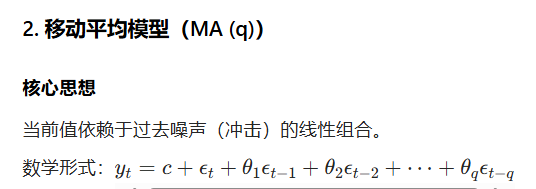

数据的波动是由短期冲击引起的（而非历史观测值），且冲击影响会随时间衰减。例如：突发事件（罢工、自然灾害）对生产的影响、测量误差。

假设一条生产线非常稳定，但偶尔会因为工人操作失误或机器小故障（这些都是随机冲击/误差）导致当天的产量出现波动。这个冲击的影响可能只会持续一两天。我们来创建一个MA(2)过程。


---------------------------------------------
--- 案例二：MA(2)模型 - 生产线意外 ---


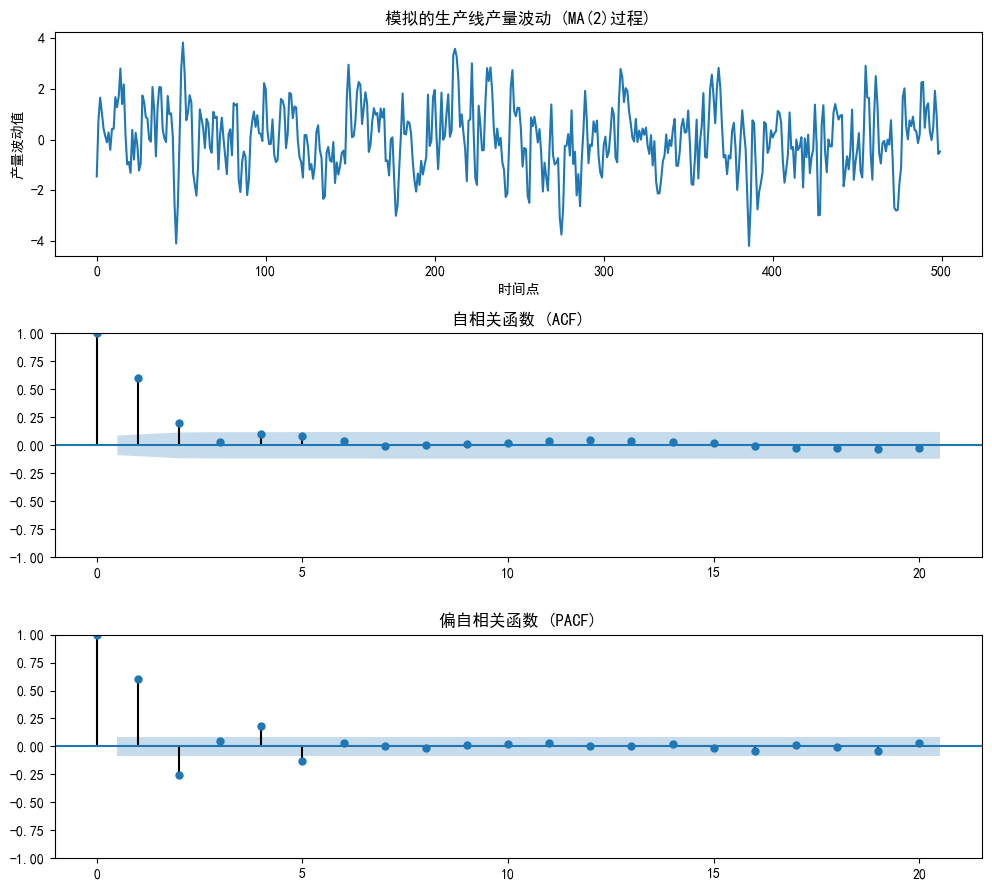

In [25]:
# --- MA(2) 案例：生产线意外 ---
print("\n" + "---"*15)
print("--- 案例二：MA(2)模型 - 生产线意外 ---")

"""
=====================
2.1 生成MA(2)时间序列
=====================
MA(2)模型数学表达式：y_t = ε_t + θ₁ε_{t-1} + θ₂ε_{t-2}
- 当前值由当前及前两期的随机冲击（ε）线性组合而成
- 适用于捕捉短期冲击对序列的影响（如生产线故障、原料短缺）
"""
# AR部分参数：因无自回归项
ar_params = np.array([])  
# MA部分参数：0.8和0.4分别是前两期冲击的权重
ma_params = np.array([0.8, 0.4])  

# 生成MA(2)过程：直接传入AR和MA系数数组（注意无参数名）
ma_process = ArmaProcess.from_coeffs(ar_params, ma_params)

# 设置随机种子保证结果可复现，生成500个样本点
np.random.seed(200)
ma_data = ma_process.generate_sample(nsample=500)


"""
============================
2.2 可视化分析时间序列特征
============================
通过观察ACF和PACF图判断模型阶数：
- MA(q)模型的ACF应在q阶后截尾（本例q=2）
- PACF应呈现拖尾特征（与AR模型区分）
"""
# 创建3个子图：时间序列图、ACF图、PACF图
fig, axes = plt.subplots(3, 1, figsize=(10, 9))

# 绘制时间序列图：展示生产线产量波动
axes[0].plot(ma_data)
axes[0].set_title('模拟的生产线产量波动 (MA(2)过程)')
axes[0].set_xlabel('时间点')
axes[0].set_ylabel('产量波动值')

# 绘制自相关函数(ACF)图：观察序列相关性衰减模式
plot_acf(ma_data, ax=axes[1], lags=20, title='自相关函数 (ACF)')
# 理论预期：MA(2)的ACF应在2阶后截尾（相关性骤降为0）

# 绘制偏自相关函数(PACF)图：剔除中间变量影响的直接相关性
plot_pacf(ma_data, ax=axes[2], lags=20, title='偏自相关函数 (PACF)')
# 理论预期：MA(2)的PACF应呈现拖尾（指数或振荡衰减）

# 优化子图布局，避免重叠
plt.tight_layout()
plt.show()

- ACF图 (自相关图)：这次轮到ACF图提供关键线索了！可以看到，在滞后1和2阶，柱子非常显著。但在2阶之后，柱子突然“截断”，掉入了置信区间。 这说明，一个随机冲击的影响最多只持续2天。ACF在2阶截尾 -> 强烈暗示 q=2。
- PACF图 (偏自相关图)：柱子呈现出缓慢衰减的“拖尾”形态。PACF拖尾，验证了MA模型的猜想。

In [26]:
# 2.3 根据ACF/PACF图的诊断，建立ARIMA(0,0,2)模型
model_ma = ARIMA(ma_data, order=(0, 0, 2)).fit()
print("\nMA(2)模型诊断报告:")
print(model_ma.summary())


MA(2)模型诊断报告:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -704.426
Date:                Thu, 26 Jun 2025   AIC                           1416.852
Time:                        23:26:03   BIC                           1433.710
Sample:                             0   HQIC                          1423.467
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0582      0.100      0.584      0.559      -0.137       0.253
ma.L1          0.8252      0.041     19.978      0.000       0.744       0.906
ma.L2          0.4180      0.041     1

型报告中，ma.L1的系数约为0.8，ma.L2的系数约为0.4，和我们设定的参数高度吻合！p值也都极其显著。再次成功破案！

## 2.3 ARMA模型 

现实世界中，很多情况是混合的。比如公司月度销售额，既有上个月业绩带来的惯性（AR成分），又会受到某次市场推广活动或负面新闻的短期冲击（MA成分）。我们来创建一个ARMA(1,1)过程。


---------------------------------------------
--- 案例三：ARMA(1,1)模型 - 公司月度销售 ---


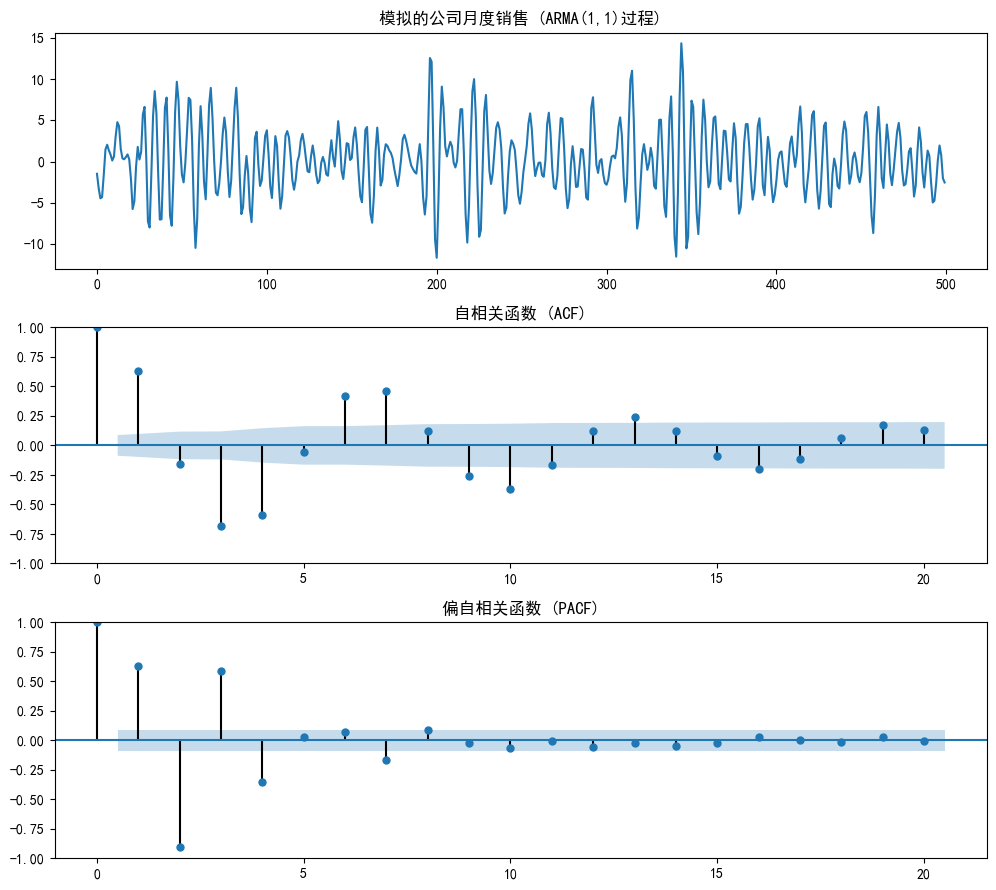

In [28]:
# --- ARMA(1,1) 案例：公司月度销售 ---
print("\n" + "---"*15)
print("--- 案例三：ARMA(1,1)模型 - 公司月度销售 ---")

# 3.1 我们来“创造”一个ARMA(1,1)过程
# 修复：直接传入系数数组，并确保包含常数项
ar_params = np.array([1, -0.8])  # AR部分: [1, -φ1]
ma_params = np.array([1, 0.5])   # MA部分: [1, θ1]

# 正确调用方式：直接传入系数数组，不使用参数名
arma_process = ArmaProcess.from_coeffs(ar_params, ma_params)

np.random.seed(300)
arma_data = arma_process.generate_sample(nsample=500)

# 3.2 作为“侦探”，我们观察数据和ACF/PACF图
fig, axes = plt.subplots(3, 1, figsize=(10, 9))
axes[0].plot(arma_data)
axes[0].set_title('模拟的公司月度销售 (ARMA(1,1)过程)')
plot_acf(arma_data, ax=axes[1], lags=20, title='自相关函数 (ACF)')
plot_pacf(arma_data, ax=axes[2], lags=20, title='偏自相关函数 (PACF)')
plt.tight_layout()
plt.show()

- ACF图 和 PACF图：这次我们发现，情况变得复杂了。ACF图和PACF图都没有出现明显的“截尾”现象，两者的柱子都是缓慢衰减，呈现“拖尾”形态。
解读：当两个图都拖尾时，这就是一个强烈的信号，说明数据背后的驱动力是混合的，既有AR成分，也有MA成分。

- 定阶：对于ARMA模型，从图上直接确定p和q的精确值会比较困难。通常我们会从低阶开始尝试，比如(1,1), (2,1), (1,2)，然后结合后续的模型评估指标（如AIC, BIC）来选择最优的。但既然两个图都是拖尾，我们就先从最简单的ARMA(1,1)开始猜起。

In [29]:
# 3.3 根据ACF/PACF图的诊断，建立ARIMA(1,0,1)模型
model_arma = ARIMA(arma_data, order=(1, 0, 1)).fit()
print("\nARMA(1,1)模型诊断报告:")
print(model_arma.summary())



ARMA(1,1)模型诊断报告:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1058.680
Date:                Thu, 26 Jun 2025   AIC                           2125.360
Time:                        23:26:39   BIC                           2142.218
Sample:                             0   HQIC                          2131.975
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1610      0.393      0.410      0.682      -0.608       0.930
ar.L1          0.5656      0.035     16.047      0.000       0.496       0.635
ma.L1          0.8998      0.021  

d:\Anaconda\envs\yolov5_new\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


模型报告中，ar.L1系数约为0.8，ma.L1系数约为0.5，都非常接近我们的设定值，且p值都为0.000。

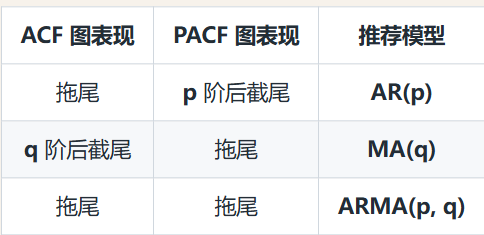

前提：以上所有判断都必须在数据平稳后进行！如果你的原始数据不平稳，请先做差分，然后对差分后的序列进行ACF/PACF分析。

这正是我们最终要学习的 ARIMA(p, d, q) 模型的由来，将在明天学习。

- AR(p): 自回归项，看PACF。
- I(d): 差分阶数 (Integrated)，看我们为了让数据平稳做了几次差分。
- MA(q): 移动平均项，看ACF。




# 总结

- 非平稳性（趋势） -> 使用差分 (.diff())
- 季节性 -> 使用季节性差分 (.diff(periods=s))
- 自相关性 -> 不消除，而是利用 ACF/PACF图 来为后续的模型选择提供线索。

- 截尾 (Cut off)：ACF或PACF图在某个延迟之后，相关系数突然变得非常小，几乎都在置信区间内。
- 拖尾 (Tail off)：相关系数随着延迟增加而缓慢、指数级地衰减，而不是突然截断。
- 如果ACF截尾，PACF拖尾 -> 考虑 MA(q) 模型。
- 如果PACF截尾，ACF拖尾 -> 考虑 AR(p) 模型。
- 如果ACF和PACF都拖尾，可能需要 ARMA(p, q) 模型。
